In [1]:
!pip install matplotlib
!pip install pillow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import struct
import string
from PIL import Image
from tensorflow import keras

In [3]:
def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3, dtype=tf.dtypes.uint8)
    
    depth_path = tf.strings.regex_replace(img_path, 'Dataset/SCDEncoded/Testing/', '')
    depth_path = tf.strings.regex_replace(depth_path, '_SCD_Encoded', '')
    depth = tf.io.read_file(depth_path)
    depth = tf.image.decode_png(depth, channels = 1)
    
    return {'image': image, 'segmentation_mask': depth}
    
    
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    ### Don't resize, crop instead! :^) 
    input_image = tf.image.resize_with_crop_or_pad(datapoint['image'], 512, 512)
    input_mask = tf.image.resize_with_crop_or_pad(datapoint['segmentation_mask'], 512, 512)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize_with_crop_or_pad(datapoint['image'], 512, 512)
    input_mask = tf.image.resize_with_crop_or_pad(datapoint['segmentation_mask'], 512, 512)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def add_gaussian_blur(image):
    image = tf.expand_dims(image, 0)
    image = tf.cast(image, tf.float32)
    blur = [tf.divide(tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype = tf.float32), 16.0)]
    blur = tf.expand_dims(blur, axis = -1)
    blur = tf.transpose(blur, [1,2,3,0])
    blurred_image = tf.nn.conv2d(image, blur, strides = (1,1), padding = 'SAME')[0]
    return blurred_image

In [4]:
encoded_path = '../Data/Dataset/SCDEncoded/'
map_path = '../Data/Dataset/BetaMap/'
models_path = '../Models/'
model_name_segmentation = 'U-Net_Faces_SCD'
model_name_classic_GAN = 'GANs/May-05-2021_error_generator'
model_name_NAC = 'May-07-2021_NAC'
model_name_multiscale = 'SCD_Error_Correction_Faces'
test_data = 'Testing/'

# SCD CONFIGS
NUM_STAIRS = 2

# DATASET CONFIGS
TESTSET_SIZE = len(os.listdir(encoded_path + test_data))
print(f"The Testing Dataset contains {TESTSET_SIZE} images.")
SEED = 123
BATCH_SIZE = 32

# Set up segmentation dataset
test_dataset = tf.data.Dataset.list_files(encoded_path + test_data + "*.png", seed=SEED)
test_dataset = test_dataset.map(parse_image)
dataset = {"test": test_dataset}
test = dataset['test'].map(load_image_test)
test_dataset = test.batch(BATCH_SIZE)

The Testing Dataset contains 230 images.


In [5]:
model_segmentation = keras.models.load_model(models_path + model_name_segmentation)
model_classic_GAN = keras.models.load_model(models_path + model_name_classic_GAN)
model_NAC = keras.models.load_model(models_path + model_name_NAC)
model_multiscale = keras.models.load_model(models_path + model_name_multiscale)

## XYZM Tools

In [6]:
def xyzmwrite(path, x, y, z, r, g, b, m):
    w, h = r.shape # This seems to be a problem with the naming scheme in the original MATLAB xyzmwrite, or I may just be dumb

    xyz = np.zeros((w*h, 3))

    xm1 = np.array(np.reshape(x, w*h, order = 'F'))
    ym1 = np.array(np.reshape(y, w*h, order = 'F'))
    zm1 =  np.array(np.reshape(z, w*h, order = 'F'))
    xyz[:, 0] = xm1
    xyz[:, 1] = ym1
    xyz[:, 2] = zm1
    xyz = np.reshape(xyz.T, w*h*3, order = 'F')

    rgb = np.zeros((w*h, 3))
    r1 = np.array(np.reshape(r, w*h, order = 'F'))
    g1 = np.array(np.reshape(g, w*h, order = 'F'))
    b1 =  np.array(np.reshape(b, w*h, order = 'F'))
    rgb[:, 0] = r1
    rgb[:, 1] = g1
    rgb[:, 2] = b1
    rgb = np.reshape(rgb.T, w*h*3, order = 'F')

    m = np.reshape(m, w*h, order = 'F')

    try:
        os.remove(path)
    except OSError:
        pass

    with open(path, 'wb') as xyzm_file:
        xyzm_file.write(b'image size width x height = %d x %d'%(w, h))
        xyzm_file.write(xyz.astype(np.float32))
        xyzm_file.write(rgb.astype(np.uint8))
        xyzm_file.write(m.astype(np.uint8))

    return None

def xyzmread(path):
    # Find height and width of data from header
    file_object = open(path, 'rb')                                              # Open file
    file_header = file_object.read(100).decode('ascii', errors = 'ignore')      # Get header as ASCII string
    file_header = ''.join(filter(lambda x: x in string.printable, file_header)) # Filter non-printable characters out
    file_header_info = file_header.split('=')                                        
    file_header_info = file_header_info[1].split('x')
    width = int(file_header_info[0])
    height_string = file_header_info[1]
    valid_height_string = ''
    for i in range(1,len(height_string)):                                       # Range 1-len(height_string) ignores the space after the 'x'
        if (ord(height_string[i]) < 48 or ord(height_string[i]) > 57):          # Do not add to valid string if values lie outside '0' - '9'
            break
        valid_height_string = valid_height_string + height_string[i]
    height = int(valid_height_string)

    # Ignore header in data
    # Additional 1's added to reflect the removal of characters in .split() method
    header_length = len(file_header.split('x')[0]) + 1 + len(file_header.split('x')[1]) + 1 + len(valid_height_string) + 1
    file_object.seek(header_length, 0)
    # Read in data
    xyz_data = []
    rgb_data = []
    m_data = []
    for i in range(0, (width*height*3)):
        (num,) = struct.unpack('f', file_object.read(4))
        xyz_data.append(num)

    for j in range(0, (width*height*3)):
        (num,) = struct.unpack('>H', b'\x00' + file_object.read(1))
        rgb_data.append(num)
    
    for k in range(0, (width*height)):
        (num,) = struct.unpack('>H', b'\x00' + file_object.read(1))
        m_data.append(num)

    xyz_data = np.reshape(xyz_data, (3, width*height), order = 'F')
    x_data = xyz_data[0,:]
    x_data = np.reshape(x_data, (width, height), order = 'F')
    y_data = xyz_data[1,:]
    y_data = np.reshape(y_data, (width, height), order = 'F')
    z_data = xyz_data[2,:]
    z_data = np.reshape(z_data, (width, height), order = 'F')

    rgb_data = np.reshape(rgb_data, (3, width*height), order = 'F')
    r_data = rgb_data[0,:]
    r_data = np.reshape(r_data, (width, height), order = 'F')
    g_data = rgb_data[1,:]
    g_data = np.reshape(g_data, (width, height), order = 'F')
    b_data = rgb_data[2,:]
    b_data = np.reshape(b_data, (width, height), order = 'F')

    m_data = np.reshape(m_data, (width, height), order = 'F')

    return x_data, y_data, z_data, r_data, g_data, b_data, m_data

def xyzmshow2d(x, y, z, r, g, b, m):
    print('Preparing 2D...')
    # plt.ion()
    # plt.show()

    fig, axs = plt.subplots(3,3)
    axs[0, 0].imshow(x)
    axs[0, 0].set_title('X')
    axs[0, 1].imshow(y)
    axs[0, 1].set_title('Y')
    axs[0, 2].imshow(z)
    axs[0, 2].set_title('Z')
    axs[1, 0].imshow(r)
    axs[1, 0].set_title('R')
    axs[1, 1].imshow(g)
    axs[1, 1].set_title('G')
    axs[1, 2].imshow(b)
    axs[1, 2].set_title('B')
    axs[2, 0].imshow(m)
    axs[2, 0].set_title('M')
    fig.delaxes(axs[2,1])
    fig.delaxes(axs[2,2]) 

    # plt.draw()
    # plt.pause(0.001)
    print('Displaying 2D...')
    plt.show()
    return

In [19]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Predicted Mask', 'True Depth', 'Predicted Depth', 'Difference Image']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        # plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, depth in dataset.take(num):
            pred_mask = model_segmentation.predict(image)
            display([image[0], depth[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
def evaluate_predictions(dataset=None, num=1):
    if dataset:
        for image, depth, in dataset.take(num):
            pred_mask = model_segmentation.predict(image)
            mask = create_mask(pred_mask)
            decoded_depth = scdDecode(image[0], mask, depth[0], verbose = True)
            
#            print(np.unique(depth[0]))
            blurred_depth = add_gaussian_blur(depth[0])
#            print(np.unique(blurred_depth))
            
#            print('Actual', 'Min Depth:', np.min(depth[0]), 'Max Depth:', np.max(depth[0]))
            print('Actual', 'Min Depth:', np.min(blurred_depth), 'Max Depth:', np.max(blurred_depth))
            print('Predicted', 'Min Depth:', np.min(decoded_depth), 'Max Depth:', np.max(decoded_depth))
                        
            display([image[0], mask, depth[0], decoded_depth, depth[0] - decoded_depth])
        
def evaluate_correction_classic_GAN(decoded_data, save_images=False):
    
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        '../Data/Dataset/Analysis_Outputs/Predicted_Depth/Testing/',label_mode=None,
        class_names=None, color_mode='grayscale', batch_size=230, image_size=(512,
        512), shuffle=False, seed=123, validation_split=None, subset=None,
        interpolation='bilinear', follow_links=False)
    
    num_depth_maps = 0
    total_sum_squared_diff = 0
    for batch in test_dataset:
        for image in batch:
            num_depth_maps = num_depth_maps + 1
            decoded_depth = image
            decoded_depth = tf.reshape(decoded_depth, [1, 512, 512, 1]) # -1 to get None first dimensions
            decoded_depth, a = normalize(decoded_depth, 0)
            corrected_depth_classic_GAN = model_classic_GAN.predict(decoded_depth)

            corrected_depth_classic_GAN = tf.cast(tf.squeeze(corrected_depth_classic_GAN, 0), tf.float64)
            corrected_depth_classic_GAN = corrected_depth_classic_GAN * 127.5 + 127.5
            decoded_depth = tf.cast(tf.squeeze(decoded_depth, 0), tf.float64)
            decoded_depth = decoded_depth * 255

            diff = tf.math.subtract(decoded_depth, corrected_depth_classic_GAN)
            squared_diff = np.power(diff, 2)
            sum_squared_diff = np.sum(squared_diff)
            total_sum_squared_diff = total_sum_squared_diff + sum_squared_diff

            if save_images:
                # Save Corrected Depth
                corrected_depth_image = tf.keras.preprocessing.image.array_to_img(corrected_depth_classic_GAN)
                plt.imsave('../Data/Dataset/Analysis_Outputs/Corrected_Depth_Classic_GAN/Testing/' + str(num_depth_maps) + '_SCD_Corrected_Depth.png', corrected_depth_image)

                # Save diff image
                diff_image = tf.keras.preprocessing.image.array_to_img(diff)
                plt.imsave('../Data/Dataset/Analysis_Outputs/Diff_Image_Classic_GAN/Testing/' + str(num_depth_maps) + '_SCD_Corrected_Diff.png', diff_image)

                x = np.linspace(0, 512, 512)
                y = x
                xx, yy = np.meshgrid(x, y)
                xyzmwrite('../Data/Dataset/Analysis_Outputs/Corrected_Depth_Classic_GAN/Testing/' + str(num_depth_maps) + '_SCD_Corrected_Depth.xyzm', xx, yy, corrected_depth_image, np.zeros([512, 512]), np.zeros([512, 512]), np.zeros([512, 512]), np.ones([512, 512]))
#                 xyzmwrite('../Data/Dataset/Analysis_Outputs/Diff_Image_Classic_GAN/Testing/' + str(num_depth_maps) + '_SCD_Corrected_Diff.xyzm', xx, yy, diff_image, np.zeros([512, 512]), np.zeros([512, 512]), np.zeros([512, 512]), np.ones([512, 512]))
#             print(tf.math.reduce_max(decoded_depth))
#             print(tf.math.reduce_min(decoded_depth))
#             print(tf.math.reduce_max(corrected_depth_classic_GAN))
#             print(tf.math.reduce_min(corrected_depth_classic_GAN))
    
    num_points = 512 * 512 * num_depth_maps
    rms_error = np.sqrt(total_sum_squared_diff / num_points)     
    print('Number of Images Tested: ', num_depth_maps)
    print('RMS Error: ', rms_error)
    
def evaluate_correction_NAC(decoded_data, save_images=False):
    
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        '../Data/Dataset/Analysis_Outputs/Predicted_Depth/Testing/',label_mode=None,
        class_names=None, color_mode='grayscale', batch_size=230, image_size=(512,
        512), shuffle=False, seed=123, validation_split=None, subset=None,
        interpolation='bilinear', follow_links=False)
    
    num_depth_maps = 0
    total_sum_squared_diff = 0
    for batch in test_dataset:
        for image in batch:
            num_depth_maps = num_depth_maps + 1
            decoded_depth = image
            decoded_depth = tf.reshape(decoded_depth, [1, 512, 512, 1]) # -1 to get None first dimensions
            decoded_depth, a = normalize(decoded_depth, 0)
            corrected_depth_NAC = model_NAC.predict(decoded_depth)

            corrected_depth_NAC = tf.cast(tf.squeeze(corrected_depth_NAC, 0), tf.float64)
            corrected_depth_NAC = corrected_depth_NAC * 127.5 + 127.5
            decoded_depth = tf.cast(tf.squeeze(decoded_depth, 0), tf.float64)
            decoded_depth = decoded_depth * 255

            diff = tf.math.subtract(decoded_depth, corrected_depth_NAC)
            squared_diff = np.power(diff, 2)
            sum_squared_diff = np.sum(squared_diff)
            total_sum_squared_diff = total_sum_squared_diff + sum_squared_diff

            if save_images:
                # Save Corrected Depth
                corrected_depth_image = tf.keras.preprocessing.image.array_to_img(corrected_depth_NAC)
                plt.imsave('../Data/Dataset/Analysis_Outputs/Corrected_Depth_NAC/Testing/' + str(num_depth_maps) + '_SCD_Corrected_Depth.png', corrected_depth_image)

                # Save diff image
                diff_image = tf.keras.preprocessing.image.array_to_img(diff)
                plt.imsave('../Data/Dataset/Analysis_Outputs/Diff_Image_NAC/Testing/' + str(num_depth_maps) + '_SCD_Corrected_Diff.png', diff_image)

                x = np.linspace(0, 512, 512)
                y = x
                xx, yy = np.meshgrid(x, y)
                xyzmwrite('../Data/Dataset/Analysis_Outputs/Corrected_Depth_NAC/Testing/' + str(num_depth_maps) + '_SCD_Corrected_Depth.xyzm', xx, yy, corrected_depth_image, np.zeros([512, 512]), np.zeros([512, 512]), np.zeros([512, 512]), np.ones([512, 512]))
#                 xyzmwrite('../Data/Dataset/Analysis_Outputs/Diff_Image_NAC/Testing/' + str(num_depth_maps) + '_SCD_Corrected_Diff.xyzm', xx, yy, diff_image, np.zeros([512, 512]), np.zeros([512, 512]), np.zeros([512, 512]), np.ones([512, 512]))
#             print(tf.math.reduce_max(decoded_depth))
#             print(tf.math.reduce_min(decoded_depth))
#             print(tf.math.reduce_max(corrected_depth_classic_GAN))
#             print(tf.math.reduce_min(corrected_depth_classic_GAN))
    
    num_points = 512 * 512 * num_depth_maps
    rms_error = np.sqrt(total_sum_squared_diff / num_points)     
    print('Number of Images Tested: ', num_depth_maps)
    print('RMS Error: ', rms_error)
    
def evaluate_correction_multiscale(decoded_data, save_images=False):
    decoded_dataset = tf.data.Dataset.from_tensors(decoded_data)
    decoded_dataset = decoded_dataset.unbatch()
    decoded_dataset = decoded_dataset.batch(1)
    
    num_depth_maps = 0
    total_sum_squared_diff = 0
    for batch in decoded_dataset:
        num_depth_maps = num_depth_maps + 1
        decoded_depth = batch
        decoded_depth = decoded_depth[0,:,:,:]
        decoded_depth = tf.reshape(decoded_depth, [1, 512, 512, 1]) # -1 to get None first dimensions
        decoded_depth, a = normalize(decoded_depth, 0)
        corrected_depth_multiscale = model_multiscale.predict(decoded_depth)
        
        corrected_depth_multiscale = tf.cast(tf.squeeze(corrected_depth_multiscale, 0), tf.float64)
        decoded_depth = tf.cast(tf.squeeze(decoded_depth, 0), tf.float64)
        decoded_depth = decoded_depth * 255
        
        diff = tf.math.subtract(decoded_depth, corrected_depth_multiscale)
        squared_diff = np.power(diff, 2)
        sum_squared_diff = np.sum(squared_diff)
        total_sum_squared_diff = total_sum_squared_diff + sum_squared_diff
        
        if save_images:
            # Save Corrected Depth
            corrected_depth_image = tf.keras.preprocessing.image.array_to_img(corrected_depth_multiscale)
            plt.imsave('../Data/Dataset/Analysis_Outputs/Corrected_Depth_Multiscale/Testing/' + str(num_depth_maps) + '_SCD_Corrected_Depth.png', corrected_depth_image)
        
            # Save diff image
            diff_image = tf.keras.preprocessing.image.array_to_img(diff)
            plt.imsave('../Data/Dataset/Analysis_Outputs/Diff_Image_Multiscale/Testing/' + str(num_depth_maps) + '_SCD_Corrected_Diff.png', diff_image)
            
            x = np.linspace(0, 512, 512)
            y = x
            xx, yy = np.meshgrid(x, y)
            xyzmwrite('../Data/Dataset/Analysis_Outputs/Corrected_Depth_Multiscale/Testing/' + str(num_depth_maps) + '_SCD_Corrected_Depth.xyzm', xx, yy, corrected_depth_image, np.zeros([512, 512]), np.zeros([512, 512]), np.zeros([512, 512]), np.ones([512, 512]))
#             xyzmwrite('../Data/Dataset/Analysis_Outputs/Diff_Image_Multiscale/Testing/' + str(num_depth_maps) + '_SCD_Corrected_Diff.xyzm', xx, yy, diff_image, np.zeros([512, 512]), np.zeros([512, 512]), np.zeros([512, 512]), np.ones([512, 512]))

    num_points = 512 * 512 * num_depth_maps
    rms_error = np.sqrt(total_sum_squared_diff / num_points)     
    print('Number of Images Tested: ', num_depth_maps)
    print('RMS Error: ', rms_error)
            
def evaluate_all_data(dataset=None, save_images=False):
    
    decoded_depth_list = []
    if dataset:
        num_images = 0
        total_sum_squared_diff = 0
        for batch in dataset:
            images = batch[0]
            depths = batch[1]
            
            for i in range(0, len(images)):
                image = images[i]
                depth = depths[i]
                depth = add_gaussian_blur(depth)
                img = tf.keras.preprocessing.image.array_to_img(image)
                plt.imsave('../Data/Dataset/Analysis_Outputs/Original_Depth/Testing/' + str(num_images) + '_SCD_Original_Depth.png', img)
                image = tf.reshape(image, [-1, 512, 512, 3]) # -1 to get None first dimensions         
                pred_mask = model_segmentation.predict(image)
                mask = create_mask(pred_mask)
        
                decoded_depth = scdDecode(image[0], mask, depth)
                decoded_depth_list.append(decoded_depth)
            
                # Calc RMS error for whole dataset
                diff = decoded_depth - depth
                squared_diff = np.power(diff, 2)
                sum_squared_diff = np.sum(squared_diff)
                total_sum_squared_diff = total_sum_squared_diff + sum_squared_diff
                
                if save_images:
                    # Save Gamma Maps to Data/Dataset/Gamma_Map/Testing
                    gamma_map = tf.keras.preprocessing.image.array_to_img(mask)
                    plt.imsave('../Data/Dataset/Analysis_Outputs/Predicted_Gamma_Map/Testing/' + str(num_images) + '_SCD_Gamma_Map.png', gamma_map)
#                     plt.imsave('../Data/Dataset/Analysis_Outputs/Original_Depth/Testing/' + str(num_images) + '_SCD_Original_Depth.png', img)
                    
                    # Save Predicted Depth
                    decoded_depth_image = tf.keras.preprocessing.image.array_to_img(decoded_depth)
                    plt.imsave('../Data/Dataset/Analysis_Outputs/Predicted_Depth/Testing/' + str(num_images) + '_SCD_Predicted_Depth.png', decoded_depth_image)

                    # Save diff image
                    diff_image = tf.keras.preprocessing.image.array_to_img(diff)
                    plt.imsave('../Data/Dataset/Analysis_Outputs/Predicted_Diff/Testing/' + str(num_images) + '_SCD_Corrected_Diff.png', diff_image)

                    x = np.linspace(0, 512, 512)
                    y = x
                    xx, yy = np.meshgrid(x, y)
                    xyzmwrite('../Data/Dataset/Analysis_Outputs/Predicted_Depth/Testing/' + str(num_images) + '_SCD_Corrected_Depth.xyzm', xx, yy, decoded_depth_image, np.zeros([512, 512]), np.zeros([512, 512]), np.zeros([512, 512]), np.ones([512, 512]))
#                     xyzmwrite('../Data/Dataset/Analysis_Outputs/Predicted_Diff/Testing/' + str(num_images) + '_SCD_Corrected_Diff.xyzm', xx, yy, diff_image, np.zeros([512, 512]), np.zeros([512, 512]), np.zeros([512, 512]), np.ones([512, 512]))

                num_images = num_images + 1
            
        num_points = decoded_depth.size * num_images

        rms_error = np.sqrt(total_sum_squared_diff / num_points)
        decoded_depth_stack = tf.stack(decoded_depth_list)   
        print('Number of Images Tested: ', num_images)
        print('RMS Error: ', rms_error)
        print(tf.size(decoded_depth_stack))
        print(tf.math.reduce_min(decoded_depth_stack))
        print(tf.math.reduce_max(decoded_depth_stack))
        print(tf.math.reduce_mean(decoded_depth_stack))
        
        return(decoded_depth_stack)

    
                
def calc_rms_error(true_depth, pred_depth):
    diff = pred_depth - true_depth
    squared_diff = np.power(diff, 2)
    sum_squared_diff = np.sum(squared_diff)
    
    num_points = pred_depth.size
    
    return np.sqrt(sum_squared_diff / num_points)

def calc_avg_abs_error(true_depth, pred_depth):
    abs_error = np.abs(pred_depth - true_depth)
    avg_abs_error = np.sum(abs_error) / pred_depth.size
    
    return avg_abs_error
    
def scdDecode(image, mask, depth, verbose = False):
    mask = np.array(mask)
    depth = np.array(depth)
    
    zmax = np.max(depth)
    zmin = np.min(depth)
    zrng = zmax - zmin
    
    # Determine decoding parameters
    nstr = NUM_STAIRS
    P = zrng / nstr
    Beta = P / 2
    
    if P == 0:
        print(depth)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(depth))
        print(P, zrng, nstr)
    
    mask = mask[:, :, 0]
    I1 = np.array(image[:,:,0])

    abs_phi = np.array(np.arccos(2 * I1 - 1))

    # Since we added 0 or 1 to gamma based on whether it's background or not
    #  the new equation is phi = +abs_phi (gamma is odd)
    #                      phi = -abs_phi (gamma is even)
    temp = mask.copy()
    temp[temp % 2 == 0] = 0
    temp[temp % 2 == 1] = 1
    temp[temp == 0] = -1
    phi = np.multiply(abs_phi, temp)

    K = np.floor(mask / 2)
    
    unwrapped_phase = phi + 2 * np.pi * K
    
    decoded_depth = unwrapped_phase * P / (2*np.pi)
    
    decoded_depth[decoded_depth < 0] = 0
    decoded_depth[decoded_depth > 255] = 255
    decoded_depth = decoded_depth[..., tf.newaxis]
    
    
    if verbose:
        print('zmin:', zmin, 'zmax:', zmax, 'zrng:', zrng)
        print('min K', np.min(K), 'max K', np.max(K))   
        print('min phase', np.min(unwrapped_phase), 'max phase', np.max(unwrapped_phase))
        print('P', P, 'zrng', zrng)
        print('Average absolute error', np.average(np.abs(depth - decoded_depth))) 
    
    return decoded_depth

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 0.6794950239269584
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


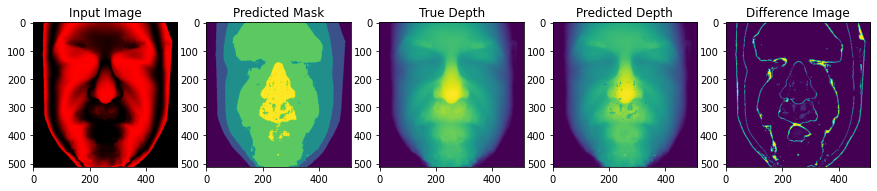

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 0.4708216265254376
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


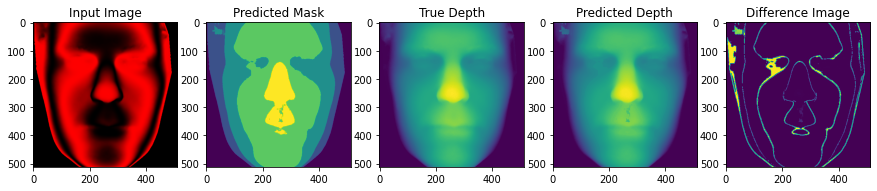

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 0.3060014573055149
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


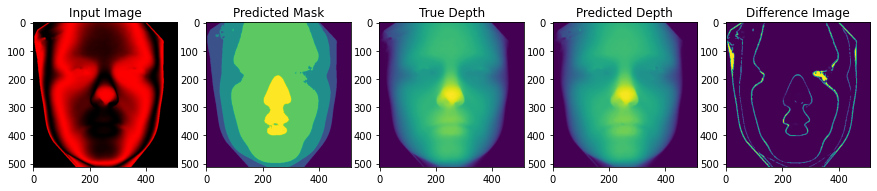

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 1.6932558489538072
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


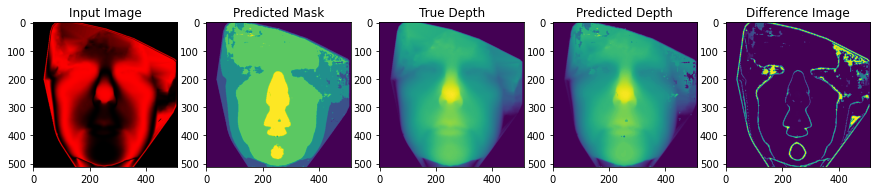

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 0.8424079831223167
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


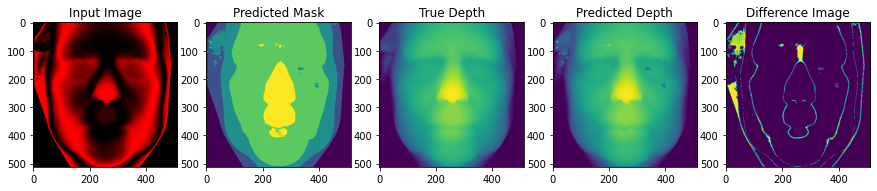

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 0.7199138528877389
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


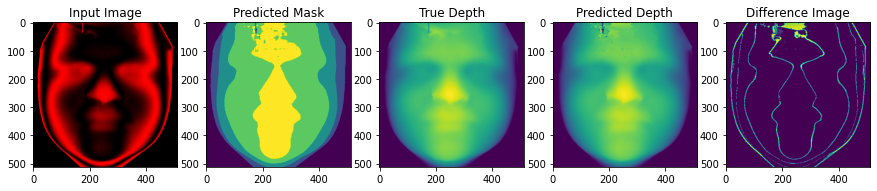

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 0.35066577633705176
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


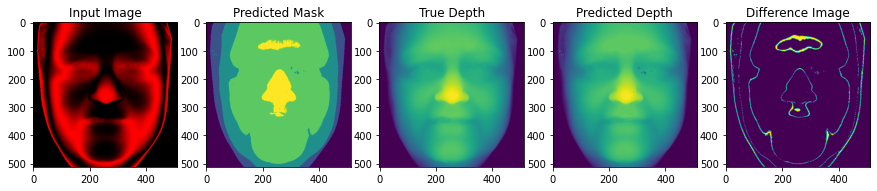

zmin: 0 zmax: 254 zrng: 254
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.0 zrng 254
Average absolute error 0.5490929852800234
Actual Min Depth: 0.0 Max Depth: 254.0
Predicted Min Depth: 0.0 Max Depth: 254.0


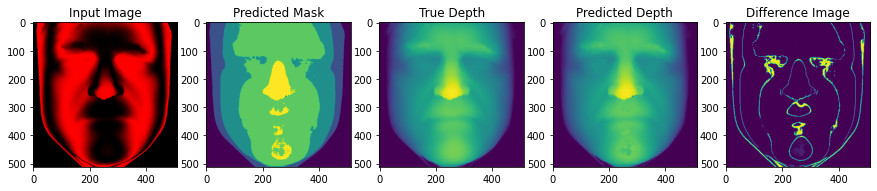

In [8]:
evaluate_predictions(test_dataset, 10)

In [21]:
decoded_depth_stack = evaluate_all_data(test_dataset, save_images=True)

Number of Images Tested:  230
RMS Error:  4.31837511643176
tf.Tensor(60293120, shape=(), dtype=int32)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(255.0, shape=(), dtype=float64)
tf.Tensor(113.94493761532671, shape=(), dtype=float64)


In [ ]:
evaluate_correction_classic_GAN(extrra, save_images=True)

In [ ]:
evaluate_correction_NAC(decoded_depth_stack, save_images=True)

In [ ]:
evaluate_correction_multiscale(decoded_depth_stack, save_images=True)